<a href="https://colab.research.google.com/github/UmmuKarimah/B21-CAP0156/blob/main/Text_Sentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
import pandas as pd

In [246]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/dataset/train.csv', encoding='latin-1')
test = pd.read_csv('/content/gdrive/MyDrive/dataset/test.csv', encoding='latin-1')
alay_dict = pd.read_csv('/content/gdrive/MyDrive/dataset/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

In [ ]:
print("Shape: ", train.shape)
train.head(15)

In [ ]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Preprocess

In [ ]:
import re
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def preprocess(text):
    text = lowercase(text) # 1
    text = remove_nonaplhanumeric(text) # 2
    text = remove_unnecessary_char(text) # 2
    text = normalize_alay(text) # 3
    return text

In [ ]:
train['Comment'] = train['Comment'].apply(preprocess)
test['Comment'] = test['Comment'].apply(preprocess)


In [ ]:
print("Shape: ", test.shape)
train.head(15)

In [ ]:
decode_map = {0: "NEGATIF", 1: "POSITIF"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
train.sentiment = train.sentiment.apply(lambda x: decode_sentiment(x))
test.sentiment = test.sentiment.apply(lambda x: decode_sentiment(x))

In [ ]:
print("TRAIN size:", len(train))
print("TEST size:", len(test))

Tokenize text

In [167]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
SEQUENCE_LENGTH=300
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train.Comment)

vocab_size = len(tokenizer.word_index) +1
print("Total words", vocab_size)

Total words 17537


In [168]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train.Comment), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test.Comment), maxlen=SEQUENCE_LENGTH)

Encoder

In [169]:
labels = train.sentiment.unique().tolist()
labels

['NEGATIF', 'POSITIF']

In [170]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train.sentiment.tolist())

y_train = encoder.transform(train.sentiment.tolist())
y_test = encoder.transform(test.sentiment.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (10000, 1)
y_test (3169, 1)


In [171]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (10000, 300)
y_train (10000, 1)

x_test (3169, 300)
y_test (3169, 1)


In [172]:
y_train[:10]

array([[0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0]])

W2vec

In [173]:
documents = [_Comment.split() for _Comment in train.Comment] 

In [174]:
import gensim
W2V_SIZE = 100
W2V_WINDOW = 5
W2V_EPOCH = 20
W2V_MIN_COUNT = 8
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=8)



w2v_model.build_vocab(documents)



In [175]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 2739


In [176]:
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

(2642397, 3690540)

Embedding layers

In [177]:
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [178]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i-1] = w2v_model.wv[word]
print(embedding_matrix.shape)

(2739, 100)


In [179]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

Build Model

In [180]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          273900    
_________________________________________________________________
dropout_3 (Dropout)          (None, 300, 100)          0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 354,401
Trainable params: 80,501
Non-trainable params: 273,900
_________________________________________________________________


In [187]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])

In [188]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [210]:
history = model.fit(x_train, y_train,
                    batch_size=100,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/10
90/90 [==============================] - 86s 933ms/step - loss: 0.4436 - acc: 0.7934 - val_loss: 0.4543 - val_acc: 0.7960
Epoch 2/10
90/90 [==============================] - 83s 919ms/step - loss: 0.4427 - acc: 0.7909 - val_loss: 0.4535 - val_acc: 0.7910
Epoch 3/10
90/90 [==============================] - 82s 915ms/step - loss: 0.4439 - acc: 0.7879 - val_loss: 0.4624 - val_acc: 0.8020
Epoch 4/10
90/90 [==============================] - 82s 916ms/step - loss: 0.4349 - acc: 0.7919 - val_loss: 0.4613 - val_acc: 0.7960
Epoch 5/10
90/90 [==============================] - 83s 918ms/step - loss: 0.4337 - acc: 0.7963 - val_loss: 0.4675 - val_acc: 0.7940
Epoch 6/10
90/90 [==============================] - 83s 919ms/step - loss: 0.4233 - acc: 0.8050 - val_loss: 0.4676 - val_acc: 0.7960
Epoch 7/10
90/90 [==============================] - 83s 920ms/step - loss: 0.4213 - acc: 0.8064 - val_loss: 0.4480 - val_acc: 0.8010
Epoch 8/10
90/90 [==============================] - 83s 924ms/step - 

Evaluate

In [211]:
score = model.evaluate(x_test, y_test, batch_size=90)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

36/36 [==============================] - 6s 155ms/step - loss: 0.5112 - acc: 0.7700

ACCURACY: 0.7699589729309082
LOSS: 0.5112320780754089


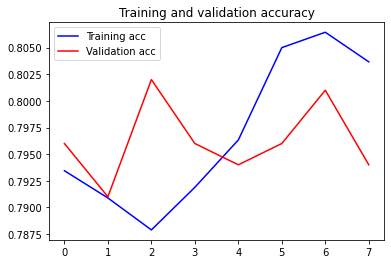

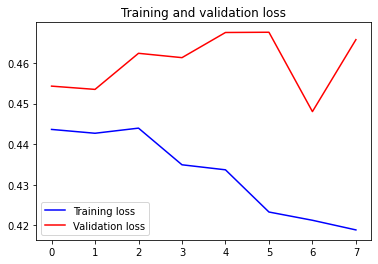

In [212]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

Predict

In [238]:
def decode_sentiment(score):
    return "NEGATIVE" if score < 0.1 else "POSITIVE"

In [239]:
def predict(text):
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score)

    return {"label": label, "score": float(score)}  

In [240]:
predict("kamu sangat jelek")

{'label': 'NEGATIVE', 'score': 0.01641601324081421}

In [241]:
predict("semua lancar tanpa kendala")

{'label': 'POSITIVE', 'score': 0.788658857345581}

In [245]:
predict("aku pernah dipukul berkali-kali")

{'label': 'POSITIVE', 'score': 0.42216742038726807}

In [221]:
model.save("text_sentiment")

INFO:tensorflow:Assets written to: text_sentiment/assets


In [223]:
!ls text_sentiment

assets	keras_metadata.pb  saved_model.pb  variables
